# Bob Ross Paintings Segmentation with UNet

Training a UNet to segment different classes from Bob Ross paintings using the [Kaggle's dataset](https://www.kaggle.com/residentmario/segmented-bob-ross-images).

In [ ]:
%%capture
!pip install ipdb
import random
import ipdb
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score as iou

import torch
from torch import nn
from torch import optim
import torch.functional as F
from torchvision.models import mobilenet_v2
from torchvision import transforms as T

torch.manual_seed(23)
np.random.seed(23)

### Download the [dataset](https://www.kaggle.com/residentmario/segmented-bob-ross-images)

In order to download the dataset, put your [kaggle.json](https://kaggle.com) credentials file in the colab content folder.

In [ ]:
%%capture
import os

if os.path.isdir('segmented-bob-ross-images'):
  # break cell execution - fun doesn't exist
  break_cell_execution()

os.environ['KAGGLE_CONFIG_DIR'] = '/content/.kaggle'
!mkdir .kaggle
!mv kaggle.json .kaggle
!chmod 600 .kaggle/kaggle.json
!kaggle datasets download -d residentmario/segmented-bob-ross-images
!mkdir segmented-bob-ross-images
!unzip segmented-bob-ross-images.zip -d segmented-bob-ross-images

### Dataset visualization

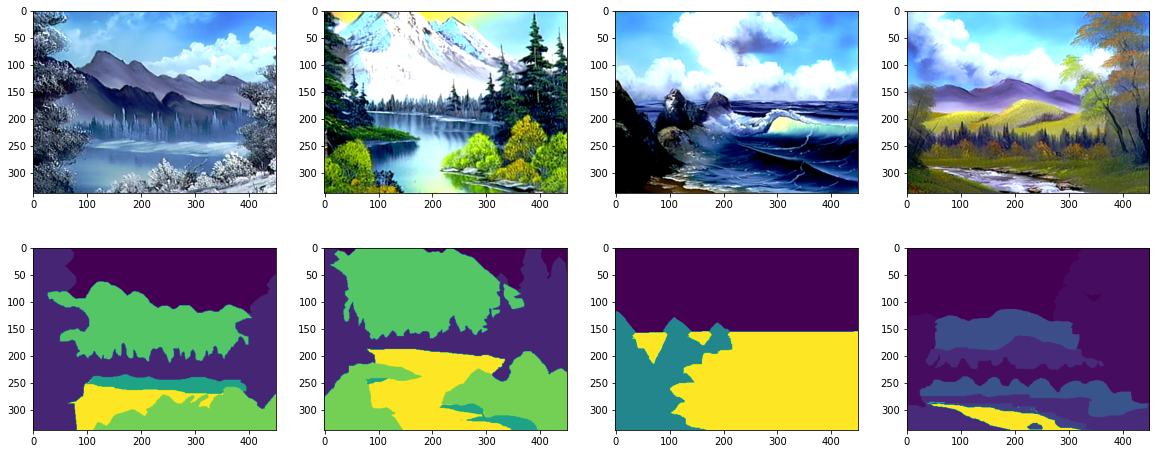

In [ ]:
# show examples

names = os.listdir('segmented-bob-ross-images/train/images')
ims_paths = [os.path.join('segmented-bob-ross-images/train/images', n) for n in names]
segs_paths = [os.path.join('segmented-bob-ross-images/train/labels', n) for n in names]

ims_paths.sort()
segs_paths.sort()

fig, ax = plt.subplots(2, 4, figsize=(20, 8))
ax = ax.ravel()

for i in range(4):
  im, seg = ims_paths[i], segs_paths[i]
  ax[i].imshow(Image.open(im))
  ax[i+4].imshow(Image.open(seg))

In [ ]:
# get the classes information

labels = pd.read_csv('segmented-bob-ross-images/labels.csv')
labels

,Id,class
0,3,sky
1,5,tree
2,10,grass
3,14,earth;rock
4,17,mountain;mount
5,18,plant;flora;plant;life
6,22,water
7,27,sea
8,61,river


This `IDs` are not representative for us, we need values between 0 and `n_classes`, to represent the indexes of the class we are predicting. We'll build a function to clean this data. To understand the clean_labels function, we need to take into account that the ID's described above are thresholds (i.e the classes representing a sky are 0,1,2,3). We need to constraint these value to 0 (as it is the first class in the csv).

Also, we have repetitive values for water, sea, and river, we'll remove the last two.

In [ ]:
def clean_labels(seg):
  # constraint names in labels
  clean_seg = seg.copy()
  prev_id = -1
  for i, id in enumerate(labels['Id']):
    clean_seg[(seg > prev_id) & (seg <= id)] = i
    prev_id = id
  return clean_seg

labels = labels.head(-2)
labels.loc[6, 'Id'] = 61  # re-set the highest value
labels

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Id,class
0,3,sky
1,5,tree
2,10,grass
3,14,earth;rock
4,17,mountain;mount
5,18,plant;flora;plant;life
6,61,water


In [ ]:
# define the num classes
num_classes = len(labels)
num_classes

7

### Create the Dataset

We'll define different helper functions to convert our images and segmentation masks to torch tensors and numpy arrays, and then a class Dataset to load our data on the go.

We need to define different transformations to make for train and validation. The extra transformations made in the training allows us to avoid overfitting by applying image augmentation.

In [ ]:
# define functions to handle our data

input_size = 128
input_crop = 128

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

def get_transforms(train=False):
  if train:
    return [
      T.Resize(input_size),
      T.CenterCrop(input_crop)
      #T.RandomCrop(input_crop),
      #T.RandomChoice([
      #  T.RandomHorizontalFlip(),
      #  T.RandomVerticalFlip(),
      #  T.RandomRotation(degrees=20)  
      #])
    ]
  else:
    return [
      T.Resize(input_size),
      T.CenterCrop(input_crop)
    ]

def to_im_tensor(im, transforms):
  preprocess = T.Compose(transforms + [T.ToTensor(), T.Normalize(means, stds)])
  tensor = preprocess(im)
  return tensor

def to_seg_tensor(im, transforms):
  preprocess = T.Compose(transforms)
  im = preprocess(im)
  seg = np.array(im)
  seg = clean_labels(seg)
  tensor = torch.from_numpy(seg)
  return tensor

def to_pil(tensor):
  transform = T.Compose([
    T.ToPILImage()
  ])
  return transform(tensor)

In [ ]:
class BobRossDataset(torch.utils.data.Dataset):
  def __init__(self, ims_paths, segs_paths, train=False):
    self.ims_paths = ims_paths
    self.segs_paths = segs_paths
    self.train = train

  def __len__(self):
    return len(self.ims_paths)

  def __getitem__(self, idx):
    im_path = self.ims_paths[idx]
    seg_path = self.segs_paths[idx]
    im, seg = Image.open(im_path), Image.open(seg_path)
    transforms = get_transforms(train=self.train)
    return to_im_tensor(im, transforms), to_seg_tensor(seg, transforms)

### Dataloader

Let's check at the size of the full dataset, split this dataset into train/test using sklearn, define a batch_size and create the dataloaders.

In [ ]:
batch_size = 23

X, y = ims_paths, segs_paths

len(X), len(y)

(250, 250)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=46)

train_dataset = BobRossDataset(X_train, y_train, train=True)
val_dataset = BobRossDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

len(train_dataset), len(val_dataset)

(167, 83)

### UNet Model

Using [the Vanilla UNet segmentation model](https://arxiv.org/pdf/1505.04597.pdf):

<img src='https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png' height=400/>

In [ ]:
class DoubleConvBlock(nn.Sequential):
  """
  Two convolutions followed by ReLU activation.
  Uses Batch Normalization and Dropout
  to avoid overfitting.
  """

  def __init__(self, in_channels, out_channels, dropout=False):
    layers = [
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, 3, padding=1),
      nn.ReLU(inplace=True)
    ]
    if dropout: layers.append(nn.Dropout())
    super(DoubleConvBlock, self).__init__(*layers)


class EncoderBlock(nn.Module):
  """
  Runs a DoubleConvBlock, saves the tensor to perform the skip connection
  and runs a max pool. Forward step returns a tuple with (x, skip).
  """
  def __init__(self, in_channels, out_channels, dropout=False):
    super(EncoderBlock, self).__init__()
    self.conv_block = DoubleConvBlock(in_channels, out_channels, dropout)
    self.max_pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv_block(x)
    skip = x.clone()
    x = self.max_pool(x)
    return x, skip


class DecoderBlock(nn.Module):
  """
  Runs an upsample, performs the skip connection and then a DoubleConvBlock.
  """
  def __init__(self, in_channels, out_channels, dropout=False):
    super(DecoderBlock, self).__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv_block = DoubleConvBlock(in_channels, out_channels, dropout)
  
  def crop(self, skip, x):
    """ Crop the skip connection to fit the concat size """
    _, _, width, height = skip.size()
    target_size = x.size()[-1]
    diff = (width - target_size) // 2
    return skip[:, :, diff:(diff + target_size), diff:(diff + target_size)]

  def forward(self, x, skip):
    x = self.upsample(x)
    skip = self.crop(skip, x)
    x = torch.cat([x, skip], axis=1)
    x = self.conv_block(x)
    return x


class CenterBlock(DoubleConvBlock):
  """ Just a DoubleConvBlock, with a cooler name. """
  def __init__(self, *args):
    super(CenterBlock, self).__init__(*args)


class FinalBlock(nn.Conv2d):
  """ Conv2d, with a cooler name. """
  def __init__(self, in_channels, n_classes):
    super(FinalBlock, self).__init__(in_channels, n_classes, kernel_size=1)


class UNet(nn.Module):
  """
  Creates three encoder blocks, a center block, three decoder blocks
  and a last layer to compute the class channels.
  Params: in_channels, n_classes
  TODO: add n_blocks as parameter
  """
  def __init__(self, in_channels, n_classes):
    super(UNet, self).__init__()
    self.down_block_1 = EncoderBlock(in_channels, 64)
    self.down_block_2 = EncoderBlock(64, 128, dropout=True)
    self.down_block_3 = EncoderBlock(128, 256, dropout=True)
    self.center_block = CenterBlock(256, 512)
    self.up_block_1 = DecoderBlock(256 + 512, 256)
    self.up_block_2 = DecoderBlock(128 + 256, 128)
    self.up_block_3 = DecoderBlock(64 + 128, 64)
    self.final_block = FinalBlock(64, n_classes)

  def forward(self, x):
    x, skip_1 = self.down_block_1(x)
    x, skip_2 = self.down_block_2(x)
    x, skip_3 = self.down_block_3(x)
    x = self.center_block(x)
    x = self.up_block_1(x, skip_3)
    x = self.up_block_2(x, skip_2)
    x = self.up_block_3(x, skip_1)
    x = self.final_block(x)
    return x

UNet(in_channels=3, n_classes=num_classes)

UNet(
  (down_block_1): EncoderBlock(
    (conv_block): DoubleConvBlock(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_block_2): EncoderBlock(
    (conv_block): DoubleConvBlock(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.5, inplace=False)
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (d

### Training algorithms

Let's define the metrics and algorithms we'll use during training.

First, we'll define the Mean Intersection Over Union or Jaccard Score and the accuracy.

In [ ]:
def mean_iou(pred, real, n_classes=num_classes):
  # convert to numpy
  pred = pred.detach().cpu().numpy()
  real = real.detach().cpu().numpy()

  # indexes for max predictions
  pred = np.argmax(pred, axis=1)

  # for each sample in the batch
  batch = zip(pred, real)
  ious = [iou(p.ravel(), r.ravel(), average='macro') for p,r in batch]

  return np.mean(ious)

def accuracy(pred, target):
  pred = torch.argmax(pred, axis=1)
  return (pred == target).float().mean()

### Hyper params

In [ ]:
lr = .001
epochs = 200

unet = UNet(in_channels=3, n_classes=num_classes)
optimizer = optim.Adam(unet.parameters(), lr=lr, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Epoch algorithm

In [ ]:
def epoch(e, mode, model, data_loader, criterion, optimizer, device, metrics):
  train = mode == 'train'
  model.train() if train else model.eval()
  model.to(device)

  # init step loss, accuracy and iou
  epoch_loss, epoch_acc, epoch_iou = 0., 0., 0.

  loop = tqdm(data_loader) if train else data_loader
  for x, y in loop:
    x, y = x.to(device).float(), y.to(device).long()

    # pass the tensor through the net
    out = model(x)

    # loss
    batch_loss = criterion(out, y.squeeze(1))
    epoch_loss += batch_loss.item() * y.size(0)

    # optimize
    if train:
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    with torch.no_grad():
      # accuracy
      batch_acc = accuracy(out, y)
      epoch_acc += batch_acc * y.size(0)
      # mean_iou
      batch_iou = mean_iou(out, y)
      epoch_iou += batch_iou * y.size(0)

    # show partial results
    if train:
      loop.set_description(f'Train Epoch {e + 1}/{epochs}')
      loop.set_postfix(loss=batch_loss.item(),
                       acc=batch_acc.item(),
                       iou=batch_iou)
  
  epoch_loss /= len(data_loader.dataset)
  epoch_acc /= len(data_loader.dataset)
  epoch_iou /= len(data_loader.dataset)

  print(f'{mode.capitalize()} Epoch {e + 1}/{epochs} '
        f'loss: {epoch_loss} '
        f'acc: {epoch_acc} '
        f'iou: {epoch_iou} ')

  metrics.add(mode, 'loss', epoch_loss)
  metrics.add(mode, 'acc', epoch_acc)
  metrics.add(mode, 'iou', epoch_iou)

### Metrics

Let's define an object to manage our metrics.

In [ ]:
class Metrics:
  def __init__(self, names):
    self.metrics = {'train': {}, 'eval': {}}
    self.names = names
    for m in names:
      self.metrics['train'][m] = []
      self.metrics['eval'][m] = []
  
  def add(self, mode, name, value):
    assert name in self.names, 'Wrong metric name'
    self.metrics[mode][name].append(value)
  
  def plot(self):
    f, ax = plt.subplots(1, len(self.names), figsize=(15, 5))
    for i, name in enumerate(self.names):
      ax[i].set_title(name)
      ax[i].plot(self.metrics['train'][name], label=f'train {name}')
      ax[i].plot(self.metrics['eval'][name], label=f'eval {name}')
      ax[i].legend()
    plt.show()

### Train, finally ...

In [ ]:
metrics = Metrics(['loss', 'acc', 'iou'])

for e in range(epochs):
  epoch(e, 'train', unet, train_loader, criterion, optimizer, device, metrics)
  epoch(e, 'eval', unet, val_loader, criterion, optimizer, device, metrics)

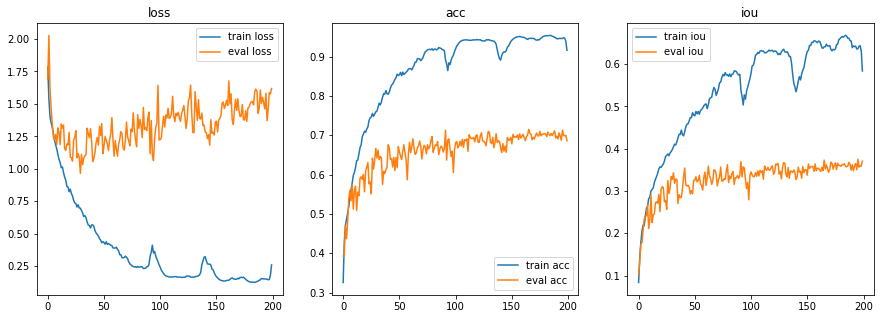

In [ ]:
metrics.plot()

### Test set

We'll use the validation data as test set, due to the lack of images. We can rest assure that these images did not affect the weights of the model, so there is no problem using these, just to check some metrics.

In [ ]:
X_test, y_test = X_val, y_val
X_test = [Image.open(x) for x in X_test]
y_test = [Image.open(y) for y in y_test]

y_pred = []
unet.eval()
for im in X_test:
  x = to_im_tensor(im, get_transforms()).unsqueeze(0).to(device)
  out = unet(x)
  out = torch.argmax(out, axis=1).squeeze(0)
  out = out.detach().cpu().float().numpy()
  y_pred.append(cv2.resize(out, im.size))

test_set = list(zip(X_test, y_test, y_pred))

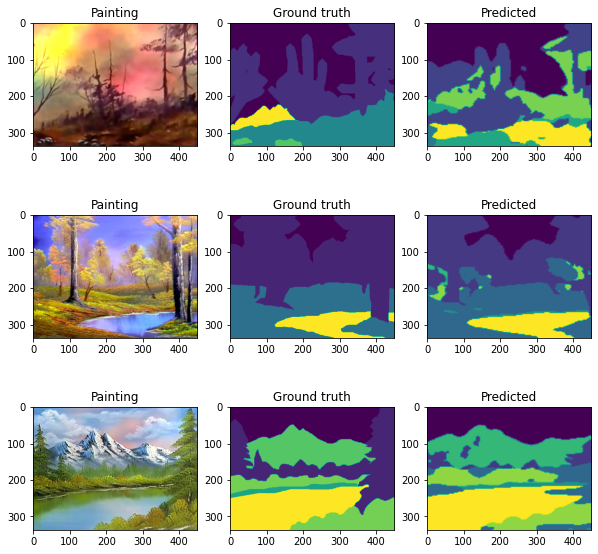

In [21]:
num_tests = 3

f, ax = plt.subplots(num_tests, 3, figsize=(10, 10))

for i in range(num_tests):
  im, gt, pred = random.choice(test_set)

  ax[i, 0].set_title('Painting')
  ax[i, 0].imshow(im)

  ax[i, 1].set_title('Ground truth')
  ax[i, 1].imshow(gt)

  ax[i, 2].set_title('Predicted')
  ax[i, 2].imshow(pred)

### Results

Even if our network did overfitting, the results are pretty good. The model needs a bit of fine tuning.